<a href="https://colab.research.google.com/github/ZhuangweiKang/VU-AD/blob/master/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
sys.path.insert(0,'../') 
import plotter as pltr
import numpy as np
import pickle as pkl
from dim_reduce import *

# from google.colab import drive
# drive.mount('/content/drive/Cisco/')

## CTF Dataset

In [2]:
ENTITY = 0
CTF_BASE_PATH = '../Dataset/CTF/processed'

X_train = pd.read_csv('%s/train/%d.csv' % (CTF_BASE_PATH, ENTITY), index_col=0).iloc[:-1]
X_test = pd.read_csv('%s/test/%d.csv' % (CTF_BASE_PATH, ENTITY), index_col=0).iloc[:-1]
with open('../Dataset/CTF/label_result/%d.pkl' % ENTITY, 'rb') as f:
    y_test = pd.DataFrame(pkl.load(f), columns=['label'])
    y_test.index = X_test.index

# remove all-zero columns that are in training or testing set
train_nonzero_cols = X_train.columns[(X_train != 0).any()]
test_nonzero_cols = X_test.columns[(X_test != 0).any()]
cols = set(train_nonzero_cols) & set(test_nonzero_cols)

X_train = X_train[cols]
X_test = X_test[cols]

train_index = X_train.index
train_lines = X_train.shape[0]
test_index = X_test.index
test_lines = X_test.shape[0]

X = pd.concat([X_train, X_test], axis=0)

In [3]:
col = 'm0'
pltr.plot_data(X, col)

In [4]:
from sklearn.preprocessing import MinMaxScaler, Normalizer

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# X_train = pd.DataFrame(X_train, columns=['m%d' % i for i in range(X_train.shape[1])], index=train_index)
# X_test = pd.DataFrame(X_test, columns=['m%d' % i for i in range(X_test.shape[1])], index=test_index)

In [5]:
from pyod.models.auto_encoder import AutoEncoder

# outlier portion in testing set
anomaly_por = y_test[y_test['label'] == 1].shape[0] / y_test.shape[0]

contamination = anomaly_por
epochs = 100
hidden_neurons=[64, 32, 32, 64]

clf = AutoEncoder(contamination=contamination, hidden_neurons=hidden_neurons, epochs=epochs, preprocessing=False, validation_size=0.3, batch_size=64)
clf = clf.fit(X_train)

y_train_pred = clf.labels_  
y_train_scores = clf.decision_scores_ 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 37)                1406      
_________________________________________________________________
dropout (Dropout)            (None, 37)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                1406      
_________________________________________________________________
dropout_1 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

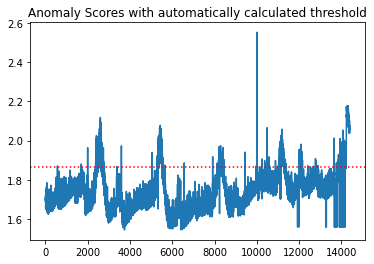

In [6]:
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

plt.plot(y_train_scores)
plt.axhline(y=clf.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');

In [32]:
threshold = 0.95
y_test_pred_proba = clf.predict_proba(X_test)[:, 1] > threshold
y_test_pred_proba = pd.DataFrame(y_test_pred_proba, columns=['label'], index=y_test.index)
pltr.plot_anomaly(X_test, y_test_pred_proba, col)

In [8]:
y_test_pred_label = pd.DataFrame(clf.predict(X_test), columns=['label'], index=y_test.index)
pltr.plot_anomaly(X_test, y_test_pred_label, col)

In [64]:
pltr.plot_anomaly(X_test, y_test, col)

In [65]:
print(y_test_pred_label[y_test_pred_label['label'] == 1].shape)
print(y_test[y_test['label'] == 1].shape)

(22651, 1)
(2128, 1)


In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix

ac = accuracy_score(y_test_pred_proba, y_test)
tn, fp, fn, tp  = confusion_matrix(y_test, y_test_pred_proba).ravel()

print('Accurancy:', ac)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

Accurancy: 0.7902252701940189
TN: 17675
FP: 3236
FN: 1597
TP: 531
